In [1]:
from pathlib import Path
from ast import literal_eval
from collections import Counter
import pickle

import pandas as pd
import numpy as np

# Build merge of best results

In [2]:
# last taken adn_circulant_brute_force_14.log
file_name = 'adn_circulant_brute_force_13.log'
data = pd.read_csv(Path('..') / 'results' / file_name, sep='|', header=0, names=['mean', 'std', 'scores_cv', 'features'])

In [3]:
data.sort_values('mean', inplace=True, ascending=False)
data.reset_index(drop=True, inplace=True)

In [4]:
nb_best_results = 50000
best_results_tmp = data.loc[: nb_best_results, :]

In [5]:
best_results_file_name = 'best_results_old.log'
best_results = pd.read_csv(Path('..') / 'results' / best_results_file_name, sep='|', header=0, names=['mean', 'std', 'scores_cv', 'features'])

In [6]:
best_results.shape

(250005, 4)

In [7]:
best_results = pd.concat([best_results, best_results_tmp])
best_results.sort_values('mean', inplace=True, ascending=False)
best_results.reset_index(drop=True, inplace=True)

In [8]:
best_results.shape

(300006, 4)

In [9]:
best_results.to_csv(Path('..') / 'results' / best_results_file_name, sep='|', index=False)

# Load data

In [2]:
file_name = 'adn_circulant_brute_force_1.log'
data = pd.read_csv(Path('..') / 'results' / best_results_file_name, sep='|', header=0, names=['mean', 'std', 'scores_cv', 'features'])

NameError: name 'best_results_file_name' is not defined

In [4]:
data.sort_values('mean', inplace=True, ascending=False)
data.reset_index(drop=True, inplace=True)

In [87]:
data.head(100)

,mean,std,scores_cv,features
0,72.8,3.9,[0.76666667 0.73333333 0.75862069 0.72413793 0...,"['5:115000001-116000000_ratio', '9:3000001-400..."
1,72.8,5.4,[0.76666667 0.63333333 0.72413793 0.79310345 0...,"['2:96000001-97000000_ratio', '5:56000001-5700..."
2,72.8,5.5,[0.73333333 0.76666667 0.62068966 0.75862069 0...,"['20:25000001-26000000_ratio', '11:114000001-1..."
3,72.8,2.2,[0.73333333 0.73333333 0.72413793 0.75862069 0...,"['1:240000001-241000000_ratio', '1:238000001-2..."
4,72.8,2.2,[0.73333333 0.73333333 0.68965517 0.72413793 0...,"['5:71000001-72000000_ratio', '12:125000001-12..."
...,...,...,...,...
95,71.4,6.2,[0.76666667 0.63333333 0.65517241 0.79310345 0...,"['16:20000001-21000000_ratio', '9:3000001-4000..."
96,71.4,3.5,[0.73333333 0.7 0.65517241 0.75862069 0...,"['2:176000001-177000000_ratio', '18:60000001-6..."
97,71.4,4.8,[0.73333333 0.73333333 0.62068966 0.75862069 0...,"['5:102000001-103000000_ratio', '4:23000001-24..."
98,71.4,5.4,[0.8 0.73333333 0.65517241 0.72413793 0...,"['8:51000001-52000000_ratio', '2:64000001-6500..."


# Find commun features

In [10]:
data = best_results

In [11]:
n_cv = 750
features_list = [literal_eval(x) for x in data.loc[:n_cv,  'features'].to_list()]
features_flat_list = [item for sublist in features_list for item in sublist]


In [12]:
c = Counter(features_flat_list)

In [13]:
nb_features = 92
features_name = [x[0] for x in c.most_common()[:nb_features]]

# Train model

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [15]:
X = pickle.load(open(Path('..') / 'features' / 'X.pkl', 'rb'))
y = pickle.load(open(Path('..') / 'features' / 'y.pkl', 'rb'))

In [16]:
X_light = X.loc[:, features_name]
#X_light = X.loc[:, new_features_set]

In [17]:
print(len([x for x in y if x ==1]))
print(len([x for x in y if x ==0]))

53
94


## automatic cross val

In [24]:
lr = LogisticRegression(class_weight='balanced', C=1)
cv_score = cross_val_score(lr, X_light, y, cv=5)

In [25]:
cv_score

array([0.76666667, 0.9       , 0.93103448, 0.86206897, 0.86206897])

In [26]:
np.mean(cv_score)

0.864367816091954

## manual cross val

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [35]:
nb_cv = 5
class_weight = {0: 1, 1: 2}
skf = StratifiedKFold(n_splits=nb_cv)
accuracy = []
models = []
train_score, test_score = [], []

for i, (idx_train, idx_test) in enumerate(skf.split(X_light, y)):
    lr = LogisticRegression(C=1, class_weight='balanced')
    lr.fit(X_light.loc[idx_train, :], np.array(y)[idx_train])
    y_train_pred = lr.predict(X_light.loc[idx_train, :])

    train_acc = accuracy_score(y_train_pred, np.array(y)[idx_train])
    #train_precision, train_recall, train_fscore, train_support = precision_recall_fscore_support(y_train_pred, np.array(y)[idx_train])
    train_score.append(precision_recall_fscore_support(y_train_pred, np.array(y)[idx_train], labels=[0, 1]))
    
    y_test_pred = lr.predict(X_light.loc[idx_test, :])
    test_acc = accuracy_score(y_test_pred, np.array(y)[idx_test])
    #test_precision, test_recall, test_fscore, test_support = precision_recall_fscore_support(y_test_pred, np.array(y)[idx_test])
    test_score.append(precision_recall_fscore_support(y_test_pred, np.array(y)[idx_test]))
    
    accuracy.append((train_acc, test_acc))
    models.append(lr)

### scores

In [36]:
print("Accuracy :")
round(100 * pd.DataFrame(accuracy, columns=['train', 'test']).mean(axis=0), 1)

Accuracy :


train    87.8
test     86.4
dtype: float64

In [37]:
mean_train_score = np.round(100 * np.sum(train_score, axis=0) / 5)
pd.DataFrame(mean_train_score, columns=[0, 1], index= ['precision', 'rappel', 'f1score', 'support'])

,0,1
precision,97.0,72.0
rappel,86.0,93.0
f1score,91.0,81.0
support,8480.0,3280.0


In [38]:
mean_test_score = np.round(100 * np.sum(test_score, axis=0) / 5)
pd.DataFrame(mean_test_score, columns=[0, 1], index= ['precision', 'rappel', 'f1score', 'support'])

,0,1
precision,97.0,68.0
rappel,84.0,94.0
f1score,90.0,78.0
support,2160.0,780.0


### coeff

In [23]:
mean_coef = np.zeros(len(features_name))
for i in range(0, nb_cv):
    mean_coef += models[i].coef_[0]
mean_coef = mean_coef / nb_cv

In [30]:
coef_lr = pd.DataFrame({'feature': X_light.columns,'weight': mean_coef})
coef_lr.sort_values('weight', ascending=False)

,feature,weight
9,5:29000001-30000000_ratio,0.772241
50,21:28000001-29000000_ratio,0.630533
0,5:37000001-38000000_ratio,0.601851
82,21:27000001-28000000_ratio,0.552940
90,5:56000001-57000000_ratio,0.537730
...,...,...
74,8:20000001-21000000_ratio,-0.632364
67,22:25000001-26000000_ratio,-0.639043
1,8:2000001-3000000_ratio,-0.647601
2,9:20000001-21000000_ratio,-0.669472


array([[<AxesSubplot:title={'center':'weight'}>]], dtype=object)

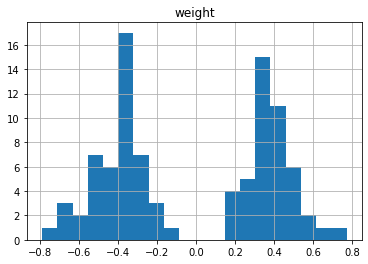

In [31]:
coef_lr.hist(bins=20)

In [42]:
threshold_features = 0.35
new_features_set = coef_lr.loc[abs(coef_lr['weight']) > threshold_features, 'feature']

In [43]:
len(new_features_set)

59

# Find best number of features

In [45]:
nb_features = range(10, 300)
res = {}
for nb_feat in nb_features:
    features_name = [x[0] for x in c.most_common()[:nb_feat]]
    X_light = X.loc[:, features_name]
    lr = LogisticRegression(class_weight='balanced')
    cv_score = cross_val_score(lr, X_light, y, cv=5)
    res[nb_feat] = np.mean(cv_score)

In [46]:
res_df = pd.DataFrame({'nb_feat': list(res.keys()), 'score': list(res.values())})

In [47]:
res_df.sort_values('score', ascending=False)

,nb_feat,score
213,223,0.850345
222,232,0.850345
221,231,0.850345
223,233,0.850345
207,217,0.850345
...,...,...
7,17,0.735632
12,22,0.735402
13,23,0.735402
9,19,0.735402


In [146]:
# For files from 1 to 13

# Best results : 140 features, n_cv=5000
# Best results : 67 features, n_cv=500, score=0.843908
# Best results : 266 features, n_cv=1000, score=0.851034
# Best results : 92 features, n_cv=750, score=0.864368

## Test pycaret

In [30]:
X_light['label'] = y

In [31]:
from pycaret.classification import *
exp_clf101 = setup(data = X_light, target = 'label', session_id=123) 

,Description,Value
0,session_id,123
1,Target,label
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(147, 68)"
5,Missing Values,0
6,Numeric Features,67
7,Categorical Features,0
8,Ordinal Features,0
9,High Cardinality Features,0


In [22]:
best_model = compare_models()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8145,0.0000,0.5650,0.9667,0.6876,0.5796,0.6354,0.0030
lr,Logistic Regression,0.7855,0.9155,0.4950,0.9667,0.6352,0.5155,0.5788,0.2730
et,Extra Trees Classifier,0.7464,0.7580,0.4900,0.8333,0.6071,0.4386,0.4797,0.0340
svm,SVM - Linear Kernel,0.7382,0.0000,0.8100,0.6930,0.7239,0.5000,0.5146,0.0030
nb,Naive Bayes,0.7345,0.7314,0.5150,0.7667,0.5876,0.4139,0.4455,0.0030
knn,K Neighbors Classifier,0.7082,0.7051,0.4000,0.6583,0.4817,0.3380,0.3574,0.1500
ada,Ada Boost Classifier,0.7073,0.7505,0.5400,0.6250,0.5555,0.3636,0.3850,0.0200
rf,Random Forest Classifier,0.7064,0.7380,0.4900,0.7333,0.5762,0.3632,0.3904,0.0410
lightgbm,Light Gradient Boosting Machine,0.6755,0.7637,0.5100,0.6333,0.5552,0.3046,0.3161,0.0080
gbc,Gradient Boosting Classifier,0.6373,0.6488,0.4900,0.6450,0.5345,0.2446,0.2695,0.0320
